<a href="https://colab.research.google.com/github/abdulkk49/Multi-Class-Text-Classification-Wines-NLP/blob/master/WIne_Variety_BERTMCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
cd /content/drive/My Drive

In [0]:
%tensorflow_version 1.x  # very important for code to work!

In [0]:
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import matplotlib.style as style
import tensorflow_hub as hub
import seaborn as sns
import sklearn.model_selection as sk
import plotly.express as px
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

In [0]:
# does not work with tensorflow 2
!pip install bert-tensorflow

In [0]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [81]:
# Set the output directory for saving model file
OUTPUT_DIR = './KnightData/BERT'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Model output directory: ./KnightData/BERT *****


In [0]:
# Load train and test data
from sklearn.preprocessing import LabelEncoder
path_to_train = './KnightData/train.csv'
path_to_test = './KnightData/test.csv'

winesdf = pd.read_csv(path_to_train)
winesdf_test = pd.read_csv(path_to_test)

We extracted 80129 years from the wine titles and 2528 did not have a year.
Removed 2528 rows with empty year values.

         points       price
year                       
1904  91.000000   40.000000
1912  89.571429         NaN
1919  88.000000   13.000000
1929  87.000000   25.000000
1945  95.000000  350.000000
1976  88.000000  101.000000
1985  91.333333  148.666667
1986  86.000000  170.000000
1988  89.600000  138.000000
1989  86.500000   53.500000
1990  90.250000  170.250000
1991  88.500000   88.000000
1992  90.692308   66.545455
1993  93.000000   65.000000
1994  88.466667   56.466667
1995  89.363636   53.448276
1996  87.850000   53.102564
1997  88.972350   43.654028
1998  87.555838   32.303109
1999  87.728285   31.921114
2000  87.397260   31.160966
2001  87.118182   26.025761
2002  87.873950   39.677570
2003  88.401294   49.336879
2004  88.826579   49.093142
2005  88.444155   43.633663
2006  88.264804   39.387672
2007  88.271581   39.277649
2008  88.307360   38.421354
2009  88.4486

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



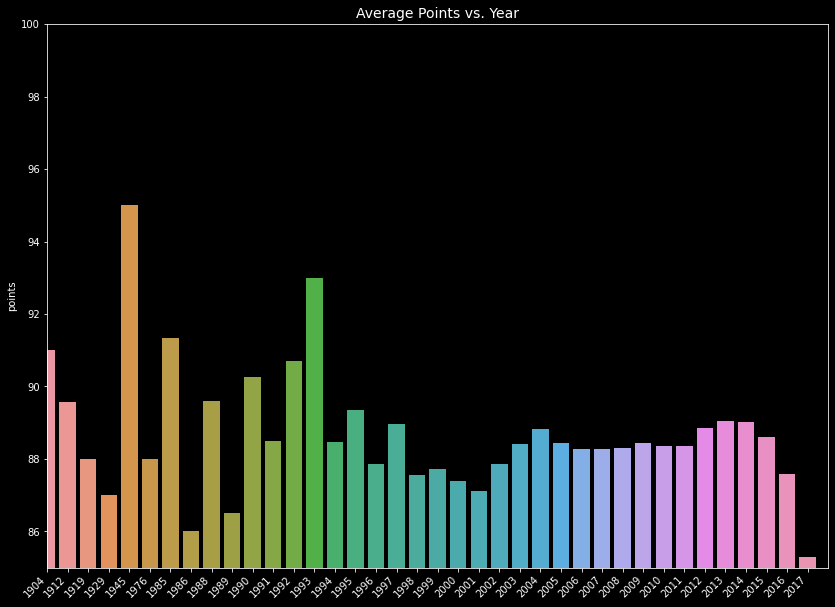

                winery
country               
US               38573
France           15948
Italy             9112
Portugal          3197
Chile             2891
Spain             2755
Argentina         2570
Austria           1892
Germany           1573
New Zealand       1121
Australia         1028
South Africa       727
Israel             320
Canada             176
Greece             139
Bulgaria            93
Romania             80
England             62
Slovenia            42
Mexico              38
Hungary             35
Moldova             35
Uruguay             33
Turkey              33
Lebanon             28
Brazil              28
Morocco             21
Georgia             12
Croatia             12
Ukraine             11
Peru                 8
Cyprus               6
Macedonia            5
Luxembourg           5
Switzerland          5
Serbia               4
Czech Republic       3
India                1
Number of countries: 38
                     points
user_name                  


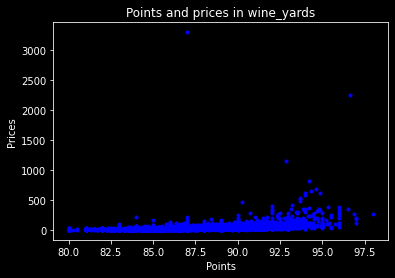

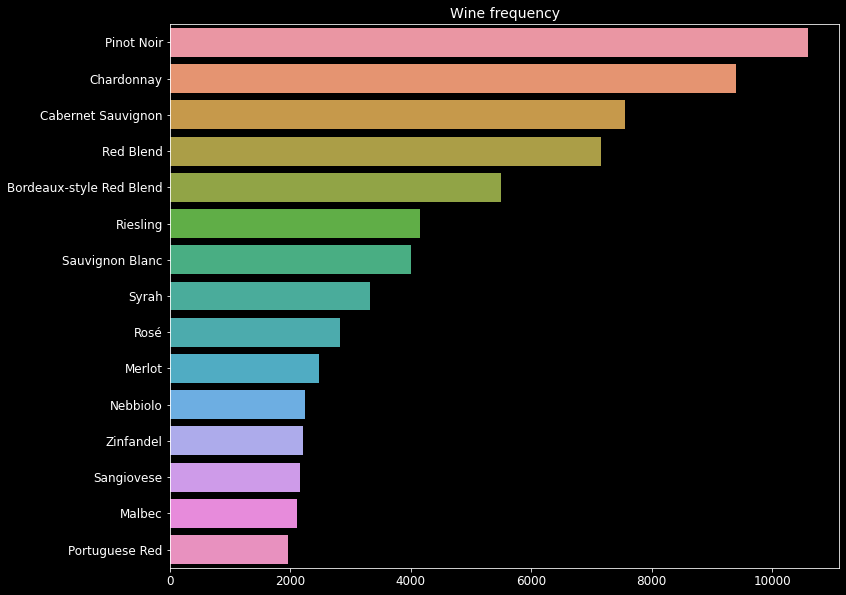

In [90]:
#===============Actionable insights===================
# Extracting feature : vintage
years = []    
for value in winesdf['review_title']:
    regresult = re.search(r'19\d{2}|20\d{2}', value)
    if regresult:
        years.append(regresult.group())
    else: years.append(None)

winesdf['year'] = years
print("We extracted %d years from the wine titles and %d did not have a year." %(len(winesdf[winesdf['year'].notna()]), len(winesdf[winesdf['year'].isna()].index)))
winesdf['year'].describe()

# Removing entries having no year value
winesdf_year = winesdf
winesdf_year = winesdf_year.dropna(subset=['year'])
print('Removed ' + str(winesdf.shape[0]-winesdf_year.shape[0]) + ' rows with empty year values.' + "\n")
winesdf_year['year'] = winesdf_year['year'].astype(int)
winesdf_year['year'].describe()

#year insights
dfWineYear = winesdf_year.groupby(['year']).mean()
print(dfWineYear)
dfWineYear = pd.DataFrame(data=dfWineYear).reset_index()
style.use("dark_background")
plt.figure(figsize=(14,10))
ax = sns.barplot(y=dfWineYear['points'], x=dfWineYear['year'])
plt.title("Average Points vs. Year", fontsize=14)
plt.xlabel("")
ax.set(
    xlim=(0, len(dfWineYear)), 
    ylim=(85, 100)
)
ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium'
)
plt.show()

#Wineyards distribution
wine_yards = winesdf[["winery", "points", "price"]].groupby("winery").mean()
points = wine_yards["points"]
prices = wine_yards["price"]
plt.plot(points, prices, "b.")
plt.title("Points and prices in wine_yards")
plt.xlabel("Points")
plt.ylabel("Prices")

# country insights
countries = winesdf[ ["country", "winery"] ].groupby(by="country").count().sort_values(by="winery")[::-1]
print(countries)
print( "Number of countries: " + str(len(countries)) )

# user insights
tasters = winesdf[ ["user_name", "points"] ].groupby(by="user_name").mean()[::-1]
print(tasters)

#Variety insights
label_freq = winesdf['variety'].apply(lambda s: str(s)).explode().value_counts().sort_values(ascending=False)
print(label_freq)
print(type(label_freq))
print()
print(list(label_freq.index))
# Bar plot
style.use("dark_background")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.iloc[:15].index)
plt.title("Wine frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [0]:
# Preprocessing to remove useless entries
processor = winesdf[[ 'review_description', 'year', 'variety', 'province' ]]
print(processor.isnull().sum())
print()
print(processor[processor['variety'].isna()].head(10))
processor = processor.dropna(subset=['review_description', 'variety'])
print('Removed ' + str(winesdf.shape[0]-processor.shape[0]) + ' rows with empty values.' + "\n")

for i in range(1,5):
    print(processor['variety'].iloc[i])
    print(processor['review_description'].iloc[i])
    print()

# data cleaning : keeping only important data
input_data = processor['review_description']
output_data = processor['variety']

maxLen = len(max(input_data, key=len).split())
print("Maximum length of a review: " + str(maxLen))

print ('There are %d varieties of wines in this dataset' % len(set(output_data)))
labelEncoder = LabelEncoder()
output_data = labelEncoder.fit_transform(output_data)

#train df
train = pd.DataFrame()
train["description"] = input_data
train["variety"] = output_data

#split into train and val
train, val =  train_test_split(train, test_size = 0.2, random_state = 100)

#test df
input_data = winesdf_test['review_description']
test = pd.DataFrame()
test["description"] = input_data

# Checking data and properties 
# winesdf.head()
# print(winesdf.info())
# print()
# print(winesdf.shape)
# print(winesdf.columns)
# winesdf.describe()

In [0]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
print("Test Set Shape :", test.shape)

In [0]:
train.columns
train['variety'].unique()
train.head().reset_index()

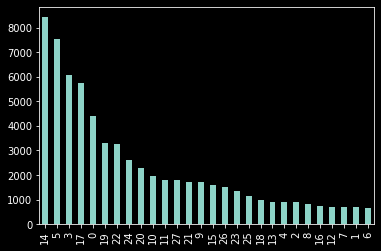

In [96]:
#Distribution of classes
train['variety'].value_counts().plot(kind = 'bar')

In [98]:
DATA_COLUMN = 'description'
LABEL_COLUMN = 'variety'
# The list containing all the classes (train['SECTION'].unique())
label_list = sorted(list(train['variety'].unique()))
print(label_list)
labels = list(labelEncoder.inverse_transform(label_list))
print()
print(labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

['Bordeaux-style Red Blend', 'Bordeaux-style White Blend', 'Cabernet Franc', 'Cabernet Sauvignon', 'Champagne Blend', 'Chardonnay', 'Gamay', 'Gewürztraminer', 'Grüner Veltliner', 'Malbec', 'Merlot', 'Nebbiolo', 'Pinot Grigio', 'Pinot Gris', 'Pinot Noir', 'Portuguese Red', 'Portuguese White', 'Red Blend', 'Rhône-style Red Blend', 'Riesling', 'Rosé', 'Sangiovese', 'Sauvignon Blanc', 'Sparkling Blend', 'Syrah', 'Tempranillo', 'White Blend', 'Zinfandel']


In [0]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [0]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\n\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\n\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\n\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________

Row 0 - text_a of training set :  Tight aromas of Montmorency cherry, rhubarb and hibiscus are spiced by cinnamon stick and vanilla-laced brioche on the complex and delicious nose of this bottling by Edgar Torres. It's a very well-rounded Pinot Noir, with dark refreshing cranberry juice at the core and ample amounts of thyme, fennel, tarragon and black pepper throughout.

__________

Row 0 - text_b of training set :  None

__________

Row 0 - label of training set :  14


In [0]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

In [0]:
# Tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

In [0]:
# sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)


In [20]:
#Example in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)


Sentence :  Tight aromas of Montmorency cherry, rhubarb and hibiscus are spiced by cinnamon stick and vanilla-laced brioche on the complex and delicious nose of this bottling by Edgar Torres. It's a very well-rounded Pinot Noir, with dark refreshing cranberry juice at the core and ample amounts of thyme, fennel, tarragon and black pepper throughout.
------------------------------
Tokens :  ['tight', 'aroma', '##s', 'of', 'mont', '##more', '##ncy', 'cherry', ',', 'r', '##hu', '##bar', '##b', 'and', 'hi', '##bis', '##cus', 'are', 'spice', '##d', 'by', 'cinnamon', 'stick', 'and', 'vanilla', '-', 'laced', 'br', '##io', '##che', 'on', 'the', 'complex', 'and', 'delicious', 'nose', 'of', 'this', 'bot', '##tling', 'by', 'edgar', 'torres', '.', 'it', "'", 's', 'a', 'very', 'well', '-', 'rounded', 'pin', '##ot', 'noir', ',', 'with', 'dark', 'refreshing', 'cr', '##an', '##berry', 'juice', 'at', 'the', 'core', 'and', 'ample', 'amounts', 'of', 'thy', '##me', ',', 'fen', '##nel', ',', 'tar', '##rag'

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [0]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [0]:
# Compute train and warmup steps from batch size
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 2.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [0]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [0]:
estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE}, warm_start_from = tf.estimator.WarmStartSettings(ckpt_to_initialize_from="./KnightData/BERT")
)

In [38]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn = train_input_fn, max_steps = 2*num_train_steps + 1000)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./KnightData/BERT', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='./KnightData/BERT', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting from: ./KnightData/BERT


INFO:tensorflow:Warm-starting from: ./KnightData/BERT


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-started 206 variables.


INFO:tensorflow:Warm-started 206 variables.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./KnightData/BERT/model.ckpt-8264


INFO:tensorflow:Restoring parameters from ./KnightData/BERT/model.ckpt-8264


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 8264 into ./KnightData/BERT/model.ckpt.


INFO:tensorflow:Saving checkpoints for 8264 into ./KnightData/BERT/model.ckpt.


INFO:tensorflow:loss = 0.8760953, step = 8264


INFO:tensorflow:loss = 0.8760953, step = 8264


INFO:tensorflow:global_step/sec: 1.61905


INFO:tensorflow:global_step/sec: 1.61905


INFO:tensorflow:loss = 0.46494025, step = 8364 (61.770 sec)


INFO:tensorflow:loss = 0.46494025, step = 8364 (61.770 sec)


INFO:tensorflow:global_step/sec: 2.09323


INFO:tensorflow:global_step/sec: 2.09323


INFO:tensorflow:loss = 0.81548357, step = 8464 (47.769 sec)


INFO:tensorflow:loss = 0.81548357, step = 8464 (47.769 sec)


INFO:tensorflow:global_step/sec: 2.09373


INFO:tensorflow:global_step/sec: 2.09373


INFO:tensorflow:loss = 0.50591254, step = 8564 (47.764 sec)


INFO:tensorflow:loss = 0.50591254, step = 8564 (47.764 sec)


INFO:tensorflow:global_step/sec: 2.09568


INFO:tensorflow:global_step/sec: 2.09568


INFO:tensorflow:loss = 0.7107759, step = 8664 (47.715 sec)


INFO:tensorflow:loss = 0.7107759, step = 8664 (47.715 sec)


INFO:tensorflow:global_step/sec: 2.0957


INFO:tensorflow:global_step/sec: 2.0957


INFO:tensorflow:loss = 0.6707184, step = 8764 (47.719 sec)


INFO:tensorflow:loss = 0.6707184, step = 8764 (47.719 sec)


INFO:tensorflow:global_step/sec: 2.09559


INFO:tensorflow:global_step/sec: 2.09559


INFO:tensorflow:loss = 0.51632226, step = 8864 (47.717 sec)


INFO:tensorflow:loss = 0.51632226, step = 8864 (47.717 sec)


INFO:tensorflow:global_step/sec: 2.09534


INFO:tensorflow:global_step/sec: 2.09534


INFO:tensorflow:loss = 0.51822436, step = 8964 (47.727 sec)


INFO:tensorflow:loss = 0.51822436, step = 8964 (47.727 sec)


INFO:tensorflow:global_step/sec: 2.09441


INFO:tensorflow:global_step/sec: 2.09441


INFO:tensorflow:loss = 0.54791594, step = 9064 (47.754 sec)


INFO:tensorflow:loss = 0.54791594, step = 9064 (47.754 sec)


INFO:tensorflow:global_step/sec: 2.09315


INFO:tensorflow:global_step/sec: 2.09315


INFO:tensorflow:loss = 0.6549672, step = 9164 (47.765 sec)


INFO:tensorflow:loss = 0.6549672, step = 9164 (47.765 sec)


INFO:tensorflow:Saving checkpoints for 9264 into ./KnightData/BERT/model.ckpt.


INFO:tensorflow:Saving checkpoints for 9264 into ./KnightData/BERT/model.ckpt.


INFO:tensorflow:Loss for final step: 0.5109963.


INFO:tensorflow:Loss for final step: 0.5109963.


Training took time  0:09:50.618320


In [39]:
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-09T18:38:30Z


INFO:tensorflow:Starting evaluation at 2020-05-09T18:38:30Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./KnightData/BERT/model.ckpt-9264


INFO:tensorflow:Restoring parameters from ./KnightData/BERT/model.ckpt-9264


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-05-09-18:40:32


INFO:tensorflow:Finished evaluation at 2020-05-09-18:40:32


INFO:tensorflow:Saving dict for global step 9264: eval_accuracy = 0.7398984, false_negatives = 306.0, false_positives = 211.0, global_step = 9264, loss = 0.85390615, true_negatives = 891.0, true_positives = 15124.0


INFO:tensorflow:Saving dict for global step 9264: eval_accuracy = 0.7398984, false_negatives = 306.0, false_positives = 211.0, global_step = 9264, loss = 0.85390615, true_negatives = 891.0, true_positives = 15124.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9264: ./KnightData/BERT/model.ckpt-9264


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9264: ./KnightData/BERT/model.ckpt-9264


{'eval_accuracy': 0.7398984,
 'false_negatives': 306.0,
 'false_positives': 211.0,
 'global_step': 9264,
 'loss': 0.85390615,
 'true_negatives': 891.0,
 'true_positives': 15124.0}

In [40]:
train_input_fn_es = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)
estimator.evaluate(input_fn=train_input_fn_es, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-09T18:41:18Z


INFO:tensorflow:Starting evaluation at 2020-05-09T18:41:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./KnightData/BERT/model.ckpt-9264


INFO:tensorflow:Restoring parameters from ./KnightData/BERT/model.ckpt-9264


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-05-09-18:46:43


INFO:tensorflow:Finished evaluation at 2020-05-09-18:46:43


INFO:tensorflow:Saving dict for global step 9264: eval_accuracy = 0.8271153, false_negatives = 855.0, false_positives = 480.0, global_step = 9264, loss = 0.59354657, true_negatives = 3915.0, true_positives = 60875.0


INFO:tensorflow:Saving dict for global step 9264: eval_accuracy = 0.8271153, false_negatives = 855.0, false_positives = 480.0, global_step = 9264, loss = 0.59354657, true_negatives = 3915.0, true_positives = 60875.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9264: ./KnightData/BERT/model.ckpt-9264


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9264: ./KnightData/BERT/model.ckpt-9264


{'eval_accuracy': 0.8271153,
 'false_negatives': 855.0,
 'false_positives': 480.0,
 'global_step': 9264,
 'loss': 0.59354657,
 'true_negatives': 3915.0,
 'true_positives': 60875.0}

In [0]:
def getPrediction(in_sentences):
  labels = list(labelEncoder.inverse_transform(label_list))
   #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]


In [0]:
pred_sentences = list(test['description'])
predictions = getPrediction(pred_sentences)

In [0]:
print(type(predictions), len(predictions), predictions[0][2], predictions[0][3])

In [0]:
enc_labels = []
act_labels = []
for i in range(len(predictions)):
  enc_labels.append(predictions[i][2])
  act_labels.append(predictions[i][3])

In [0]:
winesdf_test_copy = pd.DataFrame.copy(winesdf_test)
winesdf_test_copy["variety"] = act_labels
winesdf_test_copy.to_csv('./KnightData/test_var')

Based on https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb#scrollTo=j0a4mTk9o1Qg